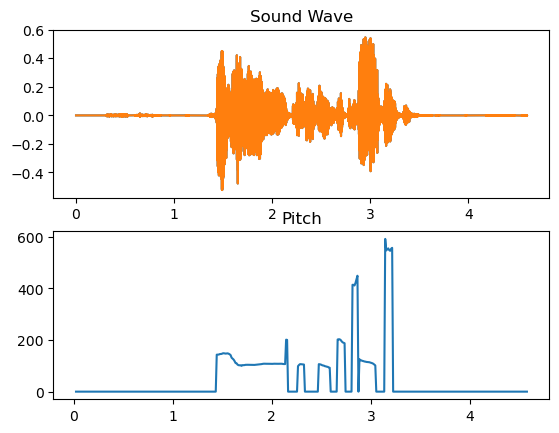

In [16]:
import parselmouth
import numpy as np

# Load the audio file
sound = parselmouth.Sound("test.wav")

# Analyze pitch
pitch = sound.to_pitch()

# Extract selected pitch values
pitch_values = pitch.selected_array['frequency']

# Print some values
pitch_values_nonzero = pitch_values[pitch_values != 0]

# You can also plot the sound wave and pitch
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(211)
plt.plot(sound.xs(), sound.values.T)
plt.title("Sound Wave")
plt.subplot(212)
plt.plot(pitch.xs(), pitch_values)
plt.title("Pitch")
plt.show()

In [17]:
jitter_rel = np.mean(np.abs(np.diff(pitch_values_nonzero)) / pitch_values_nonzero[:-1])
print(f"Relative Jitter: {jitter_rel}")

Relative Jitter: 0.08272512788126705


In [18]:
# Analyze intensity
intensity = sound.to_intensity()

# Extract intensity values
intensity_values = intensity.values.flatten()

# Calculate relative shimmer
shimmer_rel = np.mean(np.abs(np.diff(intensity_values)) / intensity_values[:-1])
print(f"Relative Shimmer: {shimmer_rel}")

Relative Shimmer: 0.04011988000131638


In [19]:
#HNR
import librosa
import numpy as np
import scipy

y, sr = librosa.load("test.wav", sr=None)
harmonic, percussive  = librosa.effects.hpss(y)

In [20]:
def calculate_hnr(y, harmonic, sr, frame_length=2048, hop_length=512):
    hnr = []

    # Frame the signal
    # need to change frame_length and hop_length
    frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
    harmonic_frames = librosa.util.frame(harmonic, frame_length=frame_length, hop_length=hop_length)

    for y_frame, h_frame in zip(frames.T, harmonic_frames.T):
        # Energy in the original frame
        energy_y = np.sum(y_frame ** 2)

        # Energy in the harmonic frame
        energy_h = np.sum(h_frame ** 2)

        # Noise energy (original - harmonic)
        energy_n = energy_y - energy_h

        # Avoid division by zero
        if energy_n <= 0:
            hnr_value = np.inf
        else:
            hnr_value = 10 * np.log10(energy_h / energy_n)

        hnr.append(hnr_value)

    return np.array(hnr)

hnr_values = calculate_hnr(y, harmonic, sr)
average_hnr = np.mean(hnr_values)
print(f"Average HNR: {average_hnr}")

Average HNR: inf


In [21]:
#NHR
def calculate_nhr(harmonic, percussive):
    # Calculate the energy of the harmonic and percussive components
    energy_harmonic = np.sum(np.square(harmonic))
    energy_percussive = np.sum(np.square(percussive))

    # Calculate NHR (avoid division by zero)
    if energy_harmonic == 0:
        return np.inf
    else:
        nhr_value = energy_percussive / energy_harmonic

    return nhr_value

nhr_value = calculate_nhr(harmonic, percussive)
print(f"NHR: {nhr_value}")

NHR: 0.8380817770957947


In [22]:
# RPDE
y_downsampled = librosa.resample(y, orig_sr=sr, target_sr=1000)

def create_recurrence_plot(data, threshold=0.1):
    # Compute the distance matrix
    m, n = len(data), len(data)
    distance_matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            distance_matrix[i, j] = abs(data[i] - data[j])

    # Apply a threshold to create the recurrence plot
    recurrence_plot = np.zeros((m, n))
    recurrence_plot[distance_matrix <= threshold] = 1

    return recurrence_plot

recurrence_plot = create_recurrence_plot(y_downsampled)



In [23]:
def calculate_rpde(recurrence_plot):
    # Extract diagonal lines from the recurrence plot
    diagonals = [recurrence_plot.diagonal(i) for i in range(-recurrence_plot.shape[0] + 1, recurrence_plot.shape[1])]

    # Calculate the distribution of diagonal lengths
    diag_lengths = [np.sum(d) for d in diagonals if np.sum(d) > 0]
    hist, _ = np.histogram(diag_lengths, bins=range(1, len(diagonals) + 1))

    # Calculate the entropy
    rpde = scipy.stats.entropy(hist, base=2)
    return rpde

rpde_value = calculate_rpde(recurrence_plot)
print("RPDE:", rpde_value)

RPDE: 11.725469747785711


In [24]:
# DFA (not working)

import nolds

# # Assuming 'data' is the time-series data
# def perform_dfa(data):
#     # Integrated time series
#     Y = np.cumsum(data - np.mean(data))
#     flucs = []
#     N = len(data)

#     # Varying box sizes
#     for n in range(16, int(N/4), 16):
#         F_n = 0
#         for i in range(0, N, n):
#             # Fit a polynomial (linear, degree=1) in each box
#             if i + n < N:
#                 x_range = range(i, i + n)
#                 y_range = Y[i:i + n]
#                 p = np.polyfit(x_range, y_range, 1)
#                 fit = np.polyval(p, x_range)
#                 # Calculate the fluctuation
#                 F_n += np.sqrt(np.sum((y_range - fit) ** 2) / n)
#         F_n /= (N / n)
#         flucs.append([n, F_n])

#     flucs = np.array(flucs)
#     # Linear fit to determine the DFA exponent
#     a = np.polyfit(np.log(flucs[:,0]), np.log(flucs[:,1]), 1)
#     return a[0]

# dfa_exponent = perform_dfa(y)
# print("DFA exponent:", dfa_exponent)

In [25]:
dfa_result = nolds.dfa(y)
print("DFA:", dfa_result)

DFA: 0.1342205631079221


In [26]:
from scipy.stats import entropy
# PPE 

f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))


In [27]:
# Remove unvoiced regions and zero frequencies
pitch_periods = 1 / f0[voiced_flag]
pitch_periods = pitch_periods[pitch_periods != np.inf]

# Ensure there are enough pitch periods for analysis
if len(pitch_periods) < 2:
    raise ValueError("Not enough voiced pitch periods for analysis.")

In [28]:
# Normalize the pitch periods
normalized_pitch_periods = (pitch_periods - np.mean(pitch_periods)) / np.std(pitch_periods)

# Calculate the histogram of normalized pitch periods
hist, bin_edges = np.histogram(normalized_pitch_periods, bins='auto', density=True)

# Calculate entropy
ppe_value = entropy(hist)
print("PPE:", ppe_value)

PPE: 1.707696522007983
